In [137]:
import pandas as pd 
import numpy as np
import pyreadstat
import plotly.express as px
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


In [117]:
df, meta = pyreadstat.read_sav("/Users/janezhang/Documents/Datathon2021/data/W1 Merged Data/Wave.1_Data/Merge/Wave1_20170906.sav")


## EDA

### Distribution of data by Country

In [118]:
country_map = {1:"Japan", 
               2:"Hong Kong", 
               3:"Taiwan", 
               4:"Korea", 
               5:"Thailand",
               6:"Philippines",
               7:"Mainland China",
               8:"Indonesia"}
df["name"] = df["country"].apply(lambda x: country_map[x])
df_country = df.groupby(["country","name"]).count().reset_index()

px.bar(df_country, "name", "idnumber", title="Distribution of data by country")

### Missing Data

In [64]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing = percent_missing.reset_index().sort_values(0)
px.bar(percent_missing, 0, "index")
percent_missing.sort_values(0, ascending=False).head(50)

,index,0
133,q095,99.705329
134,q096,99.648031
126,q088,99.517066
125,q087,99.451584
132,q094,99.320619
131,q093,99.066874
128,q090,98.788573
124,q086,98.755832
130,q092,98.600311
129,q091,98.485717


### Demographic variables: gender, age, marital status, education, repligion, and religiosity

In [128]:
variable_map = {"se002": "Gender", "se003":"Age Group", "se004":"Marital Status", "se005":"Education", "se006": "Religion", "se007":"Religiosity"}
options_map = {"se002": {1:"Male", 2: "Female"}, 
               "se003": {1:"18-19", 2:"20-24", 3:"25-29", 4:"30-34",
                        5:"35-39", 6:"40-44", 7:"45-49", 8:"50-54",
                        9:"55-59", 10:"60-70",11:"71-75", 12:"76+"},
              "se004": {1:"Married", 2:"Living-in as married", 3:"Widowed",
                       4: "Separated", 5:"Divorced", 6:"Single"},
              "se005": {1:"No formal education", 2:"Incomplete primary",
                       3:"Complete primary", 4:"Incomplete secondary: vocational",
                       5:"Complete secondary: vocational", 6:"Incomplete secondary",
                       7: "Complete secondary", 8:"Some university",
                       9:"University", 10:"Post-graduate"},
              "se006": {10:"Roman Catholic", 20:"Protestant", 30:"Jews", 40: "Islam",
                       50:"Hindu", 60: "Buddhist", 70:"Other Asian religions"},
              "se007":{1:"Several times a day", 2:"Once a day", 3:"Several times a week",
                      4:"Once a week", 5:"Once a month", 6:"Only on special religious days",
                      7: "Once a year", 8:"Less often", 9:"Practically never"},
              "q127": {
                  1:"Strongly agree", 2:"Somewhat agree", 3:"Somewhat disagree", 4:"Strongly disagree"}
              }
df["age"] = df["se003"].apply(lambda x: np.nan if x not in options_map["se003"] else options_map["se003"][x])
df["voted"] = df["q027"].apply(lambda x: "Yes" if x == 2 else "No")
df["complicated"] = df["q127"].apply(lambda x: np.nan if x not in options_map["q127"] else options_map["q127"][x])
# for i in range(2,8):
#     df["se00"+str(i)+"_name"] = df["se00"+str(i)].apply(lambda x: 
#                                                         options_map["se00"+str(i)][x["se00"+str(i)]] if x["se00"+str(i)] in options_map["se00"+str(i)] else "Nan")
for i in range(2,8):
    fig = px.histogram(df, 
                       "se00"+str(i), 
                       facet_col="name", 
                       title=variable_map["se00"+str(i)])
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
    fig.show()

### Findings

All countries have a higher proportion of females to males except for Korea. 

All countries skew toward a younger population except for Japan.

People in all countries were most frequently married. We are missing marital status data for Korea.

Japan, Taiwan, Thailand, and Mainland China are more educated on average with most people completing secondary school. Korea has a higher percentage of people in people who had incomplete of complete vocational secondary school

### Prediction Model

In [93]:
df = df[df.q131.notna()]
X = df[["country", "se002", "se003", "se004", "se005", "se006", "se007"]]
y = df[["q131"]]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean.fit(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = imp_mean.transform(X_train)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

clf.predict(X_test) 

/Users/janezhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



array([[ 7.,  2.,  4., ...,  9.,  3.,  6.],
       [ 1.,  2.,  7., ...,  2., 11.,  9.],
       [ 3.,  2.,  5., ...,  7.,  9.,  1.],
       ...,
       [ 3.,  2.,  9., ...,  3.,  5.,  5.],
       [ 4.,  1.,  3., ...,  5., 11.,  6.],
       [ 5.,  2.,  5., ...,  8.,  5.,  6.]])

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

RF: 0.519260 (0.014553)


/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/janezhang/an

Log: 0.511610 (0.009241)


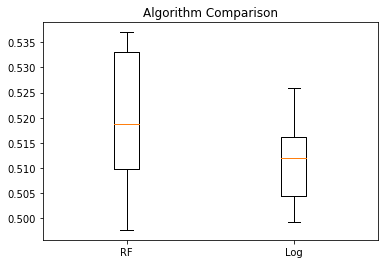

In [99]:
models = []
models.append(('RF', RandomForestClassifier()))
models.append(('Log', LogisticRegression()))
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 cv_results = cross_val_score(model, X_train, y_train, cv=5)
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

## Creating Political Participation, Political Satisfaction, and Economic Scores

In [4]:
df_clean = df[["country", 
    "q027", 
    "q029", 
    "q127",
    "q098", 
    "q130",
    "q106",
    "q131",
   "q005",
   "q006",
   "q111"]]
df_clean["name"] = df_clean["country"].apply(lambda x: country_map[x])
df.to_csv("clean_data.csv")

/Users/janezhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Remove variables with too many missing values

In [25]:
def get_valid_data_cols(df):
    df_miss = df.isnull().sum() * 100 / len(df)
    df_miss = df_miss.reset_index()
    print(df_miss)
    df_miss = df_miss[df_miss[0] <= 30]
    return list(df_miss["index"])
    

In [27]:
dfs = []
for i in range(1,8):
    df_country = df_clean[df_clean.country == i]
    keep_cols = get_valid_data_cols(df_country)
    print(i)
    df_country = df_country[[c for c in df_country.columns if c in keep_cols]]
    dfs.append(df_country)

      index          0
0   country   0.000000
1      q027   4.866008
2      q029   2.256700
3      q127   8.815233
4      q098   8.180536
5      q130  14.174894
6      q106   8.039492
7      q131   9.308886
8      q005   0.987306
9      q006  11.918195
10     q111   5.571227
11     name   0.000000
1
      index           0
0   country    0.000000
1      q027   38.471023
2      q029   37.854501
3      q127    4.685573
4      q098   16.399507
5      q130   10.234279
6      q106   14.796547
7      q131    7.274969
8      q005    1.109741
9      q006   13.686806
10     q111  100.000000
11     name    0.000000
2
      index         0
0   country  0.000000
1      q027  2.400000
2      q029  0.000000
3      q127  0.000000
4      q098  0.666667
5      q130  0.066667
6      q106  0.000000
7      q131  0.066667
8      q005  0.133333
9      q006  0.066667
10     q111  0.000000
11     name  0.000000
3
      index          0
0   country   0.000000
1      q027  42.035815
2      q029  45.554508
3    

In [7]:
for df in dfs:
    name = df.name.iloc[0]
    df.to_csv(name+"_data.csv")

In [204]:
for df in dfs:
    print(df.corr())

Japan
         country      q027      q029      q127      q098      q130      q106  \
country      NaN       NaN       NaN       NaN       NaN       NaN       NaN   
q027         NaN  1.000000  0.192016  0.114046  0.029820 -0.029152  0.017015   
q029         NaN  0.192016  1.000000  0.064448 -0.011818  0.017104  0.024375   
q127         NaN  0.114046  0.064448  1.000000 -0.014087 -0.064275  0.061081   
q098         NaN  0.029820 -0.011818 -0.014087  1.000000 -0.203170  0.263363   
q130         NaN -0.029152  0.017104 -0.064275 -0.203170  1.000000 -0.128954   
q106         NaN  0.017015  0.024375  0.061081  0.263363 -0.128954  1.000000   
q131         NaN -0.081139 -0.047794 -0.068820 -0.230128  0.338252 -0.180329   
q005         NaN -0.003539 -0.054443 -0.010947  0.071699 -0.013983  0.079065   
q006         NaN  0.004574 -0.024524 -0.014837  0.047407 -0.003066  0.054244   
q111         NaN  0.055965 -0.047982  0.014101  0.196223 -0.145933  0.386800   

             q131      q005      

The highest correlation between two of our score variables is between q005 (how would you compare the current economic situation of your family to what it was a few years ago?) and q006 (What do you think the economic situation of your family will be in a few years from now?) with a Pearson correlation coefficient of 0.32.

### Normalizing all the question scores

Political Participation

q027: 1,2 (remove 7 and 8)

q029: 1,2 (remove 7 and 9)

q127: 1-4


Political Satisfaction

q098: 1-4

q130: 1-4

q106: 1-5

q131: 1-4


Economic Satisfaction

q005: 1-5

q006: 1-5

q111: 1-5

In [8]:
q_mappings = {"q127":4, "q130":4, "q131":4,"q098":4, 
     "q106":5, "q005":5,"se009":5,"q006":5,"q111":5,
    "q027":2, "q029":2}
def normalize_col(col, name):
    if name == "q029" or name == "q027":
        col.apply(lambda x: np.nan if x not in [1,2] else x)
        
    return col/q_mappings[name]

In [9]:
def calculate_scores(df):
    mappings = {"political_participation":["q027", "q029", "q127"],
    "political_satisfaction":["q98", "q106","q131","q130"],
    "economic_satisfaction":["q005", "q009","q006","q111"]}
    
    for key in mappings.keys():
        avail_cols = []
        total_score = 0
        for col in mappings[key]:
            if col in df.columns:
                avail_cols.append(col)
                total_score += q_mappings[col]
        df[key] = df[avail_cols].sum(axis=1)/total_score

In [21]:
countries = list(df_clean.name.unique())
countries.remove("Indonesia")
dfs = []
for country in countries:
    dfs.append(pd.read_csv("imputed_data/"+country.lower().replace(" ","_")+"_imputed.csv"))
    dfs[-1]["name"] = country


In [22]:
dfs

[      Unnamed: 0  V1  V2  V3  V4  V5  V6  V7  V8   name
 0              1   2   2   2   3   2   4   3   5  Korea
 1              2   2   3   2   3   2   3   3   4  Korea
 2              3   3   2   2   3   2   3   4   5  Korea
 3              4   3   3   2   3   2   2   4   5  Korea
 4              5   2   3   2   3   2   3   2   5  Korea
 ...          ...  ..  ..  ..  ..  ..  ..  ..  ..    ...
 3178        3179   2   3   2   4   2   4   4   5  Korea
 3179        3180   2   1   2   4   2   1   4   5  Korea
 3180        3181   2   3   2   4   2   5   4   4  Korea
 3181        3182   2   3   2   3   2   2   3   5  Korea
 3182        3183   2   3   2   4   2   2   2   5  Korea
 
 [3183 rows x 10 columns],
      Unnamed: 0  V1  V2  V3  V4  V5  V6  V7       name
 0             1   2   1   3   3   2   1   3  Hong Kong
 1             2   3   3   2   3   2   3   3  Hong Kong
 2             3   2   3   3   2   3   4   2  Hong Kong
 3             4   2   3   3   3   3   4   2  Hong Kong
 4     

In [30]:
for df in dfs:
    for col in df:
        if col != "country" and col != "name":
            df[col] = normalize_col(df[col], col)
    calculate_scores(df)

In [31]:
dfs

[      country  q027  q029  q127  q098  q130  q106  q131  q005  q006  q111  \
 3994      1.0   1.0   0.5  0.50  0.50  0.50   0.2  0.75   0.6   0.6   0.4   
 3995      1.0   1.0   0.5  0.25  1.00  0.75   NaN   NaN   0.4   0.6   0.8   
 3996      1.0   1.0   1.0  0.50  0.50   NaN   0.8  1.00   0.2   NaN   0.8   
 3997      1.0   1.0   0.5  0.25  0.75  0.75   0.4  0.75   0.4   0.6   0.8   
 3998      1.0   NaN   0.5  0.50  0.75  0.75   1.0  1.00   0.8   NaN   1.0   
 ...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
 5407      1.0   1.0   0.5  0.50  0.75  0.75   0.8  0.75   0.4   0.6   1.0   
 5408      1.0   1.0   0.5  0.25  0.50  0.50   0.8  1.00   0.4   NaN   1.0   
 5409      1.0   1.0   1.0  0.25  0.50  1.00   0.8  1.00   0.4   NaN   1.0   
 5410      1.0   1.0   0.5  1.00  0.75  0.75   0.8  1.00   0.6   0.6   0.8   
 5411      1.0   0.5   0.5   NaN   NaN  1.00   0.8  1.00   0.6   0.6   0.8   
 
        name  political_participation  political_satisfaction 

In [132]:
sum(df_clean[["q005", "se009","q006","q111"]])

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [129]:
x = ["se002", "se003", "se005", "se009","q056", "q098", "q131", "q127", "q027", "complicated","age","voted"]

df_taiwan = df[df.name=="Taiwan"]


In [130]:
df_taiwan = df_taiwan[x]
df_taiwan_miss = df_taiwan.isnull().sum() * 100 / len(df_taiwan)

In [131]:
df_taiwan.describe()

,se002,se003,se005,se009,q056,q098,q131,q127,q027
count,1500.000000,1500.000000,1500.000000,1205.000000,1500.000000,1490.000000,1499.000000,1500.000000,1464.000000
mean,1.504000,5.856000,6.843333,2.276349,2.347333,2.615436,2.759173,2.626000,1.843579
std,0.500151,2.689502,1.904348,0.948410,0.785984,0.543998,0.746179,0.777084,0.363378
min,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,4.000000,7.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,5.000000,7.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000
75%,2.000000,8.000000,8.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000
max,2.000000,12.000000,10.000000,5.000000,4.000000,4.000000,4.000000,4.000000,2.000000


In [132]:
df_taiwan.to_csv("eda_taiwan_data.csv")

### EDA

In [71]:
df_taiwan

,se002,se003,se005,se009,q056,q098,q131,q127,q027
5412,1.0,2.0,7.0,3.0,3.0,2.0,4.0,4.0,NaN
5413,1.0,2.0,7.0,2.0,2.0,3.0,4.0,3.0,1.0
5414,1.0,2.0,7.0,3.0,3.0,3.0,2.0,4.0,2.0
5415,1.0,2.0,8.0,2.0,2.0,2.0,3.0,4.0,1.0
5416,1.0,3.0,9.0,3.0,2.0,3.0,3.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...
6907,2.0,9.0,3.0,1.0,1.0,2.0,3.0,3.0,1.0
6908,2.0,9.0,3.0,1.0,1.0,3.0,3.0,2.0,2.0
6909,2.0,10.0,4.0,1.0,2.0,4.0,3.0,2.0,2.0
6910,2.0,10.0,3.0,1.0,1.0,2.0,3.0,2.0,2.0


In [73]:
px.histogram(df_taiwan, "se002", title="Gender")

In [75]:
px.histogram(df_taiwan, "se003", title="Age")

In [76]:
px.histogram(df_taiwan, "se005", title="Education")

In [77]:
px.histogram(df_taiwan, "se009", title="Monthly Household Income")

In [78]:
px.histogram(df_taiwan, "q131", title="You can generally trust the people who run our government to do what is right. 1- Strongly Agree, 4 - Strongly Disagree")

In [80]:
px.histogram(df_taiwan, "q056", title="How interested would you say you are in politics?")


In [82]:
px.histogram(df_taiwan, "q098", title="How satisfied or disatisfied are you with the way democracy works in our country?")


In [84]:
px.histogram(df_taiwan, "q127", title="Sometime politics seems complicated 1-Strongly Agree, 4-Strongly Disagree")


In [86]:
px.histogram(df_taiwan, "q027", title="Did you vote in the most recent election?")


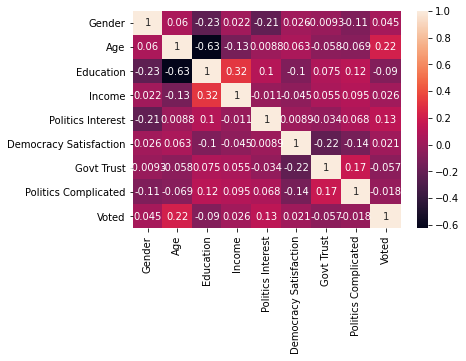

In [107]:
import seaborn as sns
q_mappings = {"se002": "Gender", "se003":"Age", "se005": "Education", "se009":"Income", "q056":"Politics Interest", "q098":"Democracy Satisfaction","q131":"Govt Trust", "q127":"Politics Complicated","q027":"Voted"}
corr = df_taiwan.corr()
sns.heatmap(corr, xticklabels=list(map(lambda x: q_mappings[x], corr)), yticklabels=list(map(lambda x: q_mappings[x], corr)), annot=True)


In [133]:
df_taiwan.groupby(["complicated","voted"]).describe()

se002                                               \
                         count      mean       std  min  25%  50%  75%  max   
complicated       voted                                                       
Somewhat agree    No      98.0  1.510204  0.502466  1.0  1.0  2.0  2.0  2.0   
                  Yes    515.0  1.557282  0.497191  1.0  1.0  2.0  2.0  2.0   
Somewhat disagree No     117.0  1.384615  0.488597  1.0  1.0  1.0  2.0  2.0   
                  Yes    493.0  1.432049  0.495864  1.0  1.0  1.0  2.0  2.0   
Strongly agree    No      15.0  1.600000  0.507093  1.0  1.0  2.0  2.0  2.0   
                  Yes     60.0  1.783333  0.415450  1.0  2.0  2.0  2.0  2.0   
Strongly disagree No      35.0  1.400000  0.497050  1.0  1.0  1.0  2.0  2.0   
                  Yes    167.0  1.544910  0.499477  1.0  1.0  2.0  2.0  2.0   

                         se003            ... q127        q027                 \
                         count      mean  ...  75%  max  count mean  std  min   
complicated       voted                   ...                                   
Somewhat agree    No      98.0  3.959184  ...  2.0  2.0   82.0  1.0  0.0  1.0   
                  Yes    515.0  6.124272  ...  2.0  2.0  515.0  2.0  0.0  2.0   
Somewhat disagree No     117.0  4.230769  ...  3.0  3.0  104.0  1.0  0.0  1.0   
                  Yes    493.0  6.160243  ...  3.0  3.0  493.0  2.0  0.0  2.0   
Strongly agree    No      15.0  5.533333  ...  1.0  1.0   13.0  1.0  0.0  1.0   
                  Yes     60.0  7.883333  ...  1.0  1.0   60.0  2.0  0.0  2.0   
Strongly disagree No      35.0  4.571429  ...  4.0  4.0   30.0  1.0  0.0  1.0   
                  Yes    167.0  5.952096  ...  4.0  4.0  167.0  2.0  0.0  2.0   

                                             
                         25%  50%  75%  max  
complicated       voted                      
Somewhat agree    No     1.0  1.0  1.0  1.0  
                  Yes    2.0  2.0  2.0  2.0  
Somewhat disagree No     1.0  1.0  1.0  1.0  
                  Yes    2.0  2.0  2.0  2.0  
Strongly agree    No     1.0  1.0  1.0  1.0  
                  Yes    2.0  2.0  2.0  2.0  
Strongly disagree No     1.0  1.0  1.0  1.0  
                  Yes    2.0  2.0  2.0  2.0  

[8 rows x 72 columns]

## Prediction Model

In [134]:
df_taiwan = df_taiwan[df_taiwan.q027.notna()]
X = df_taiwan[["se002", "se003", "se005", "se009","q056", "q098", "q131", "q127"]]
y = df_taiwan[["q027"]]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean.fit(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = imp_mean.transform(X_train)

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

RF: 0.808163 (0.014286)


/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/janezhang/ana

Log: 0.836735 (0.003227)
DT: 0.727551 (0.046043)


/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/Users/janezhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

KNN: 0.823469 (0.010990)


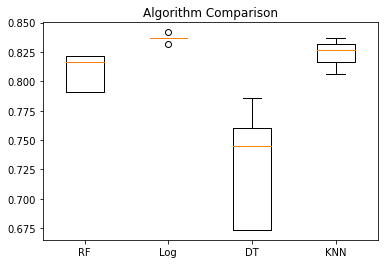

In [142]:
models = []
models.append(('RF', RandomForestClassifier()))
models.append(('Log', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('KNN', KNeighborsClassifier()))
results = []
names = []
for name, model in models:
 cv_results = cross_val_score(model, X_train, y_train, cv=5)
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [ ]:
model = LogisticRegression()
  param_search = {
      'fit_intercept': [False, True],
      'normalize' : [False, True]
  }
  gsearch = GridSearchCV(estimator=model, 
                         cv=10, 
                         param_grid=param_search, 
                         scoring = rmse_score)
  gsearch.fit(x_train, y_train)
  best_model = gsearch.best_estimator_

In [153]:
df_wave2, meta = pyreadstat.read_sav("/Users/janezhang/Documents/Datathon2021/data/W2 Merged Data/2w-3rd_release_all/merge/Wave2_20170724.sav")


In [154]:
df_taiwan2 = df_wave2[df_wave2.country == 7]

q_mappings = {"q38":"voting","q49":"political", "se3a":"age"}

ages = {(18-19), 2:"20-24", 3:"25-29", 4:"30-34",
                        5:"35-39", 6:"40-44", 7:"45-49", 8:"50-54",
                        9:"55-59", 10:"60-70",11:"71-75", 12:"76+"}
x = ["q38", "q49", "se3a"]

df_taiwan2 = df_taiwan2[x]
df_taiwan2["q38"] = df_taiwan2["q38"].apply(lambda x: x if x== 1 or x== 2 else np.nan)
df_taiwan['q49'] = df_taiwan2['q49'].apply(lambda x if x in [1,2,3,4] else np.nan)
df_taiwan2['se3a'].apply(lambda x: )

In [159]:
df_taiwan2.se3a.unique()

array([58., 34., 40., 25., 21., 31., 70., 26., 57., 50., 41., 81., 22.,
       35., 69., 66., 47., 33., 37., 79., 36., 38., 67., 24., 42., 49.,
       28., 29., 27., 30., 59., 44., 53., 32., 76., 45., 46., 39., 68.,
       64., 56., 52., 51., 73., 23., 71., 86., 72., 75., 63., 82., 62.,
       55., 74., 61., 54., 48., 65., 77., 60., 84., 43., 83., 78., 85.,
       80., 88., 94.])

In [ ]:
def age_cat(age):
    if age < 19:
        return 1
    elif age >= 20 and age <= 24:
        return 2
    elif age >= 25 and age <=29:
        return 3
    elif age >= 30 and age <= 34:
        return 4
    elif age >= 35 and age <=39:
        return 5
    elif age >= 40 and age <= 44:
        return 6
    elif age >= 45 and age <= 49:
        return 7
    elif age >= 50 and age <= 54:
        return 8
    elif age >= 55 and age <=59:
        return 9
    elif age >= 60 and age <= 70:
        return 10
    elif age 